전력사용량T는 기본 데이터와 시간과 값만 주고 LSTM을 주는 파일이다.

데이터 불러오기
--

In [1]:
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [2]:
import io
import pandas as pd

train=pd.read_csv('train.csv', encoding='cp949', parse_dates=['date_time'])
test=pd.read_csv('test.csv', encoding='cp949', parse_dates=['date_time'])
sample_submission=pd.read_csv('sample_submission.csv', encoding='cp949', parse_dates=['num_date_time'] )

In [3]:
df_train=pd.DataFrame(train)
df_test=pd.DataFrame(test) 
df_sample_submission=pd.DataFrame(sample_submission)

In [4]:
df_train['month_day'] = df_train['date_time'].dt.strftime('%m%d')
df_test['month_day'] = df_test['date_time'].dt.strftime('%m%d')

tn_month_day=pd.Series(df_train['month_day'], dtype=int)
te_month_day=pd.Series(df_test['month_day'], dtype=int)

df_train['month_day'] =tn_month_day
df_test['month_day']=te_month_day

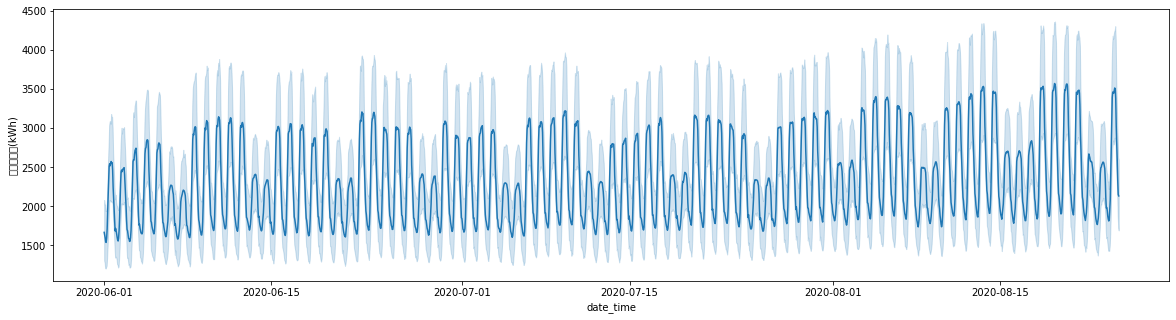

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(20,5))
sns.lineplot(x=df_train['date_time'], y=df_train['전력사용량(kWh)'], data=df_train)

모델 적용전 전처리
--


In [6]:
import pandas as pd
time_table=pd.pivot_table(df_train, index='date_time', columns='num', values='전력사용량(kWh)')
time_table.head()

num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,8179.056,977.184,3183.624,339.552,3063.744,527.58,1313.658000,4801.977000,1255.932,417.960,581.04,441.072,640.872,1084.536,2392.254000,1514.700,490.59,1408.941,640.062,1136.484,1103.544,850.176,1395.49500,2268.864,1087.344,1952.424,537.30,1355.508,357.210,5032.908,5606.064,2343.384,2529.360,530.388,553.824,797.472,1476.720,3356.64,1103.706,1897.983,411.966,3024.000,1044.360,1697.436,847.368,675.648,1298.592,340.335,943.92,824.040,1318.194,2764.80,958.554,5273.424,1400.544,471.096,2401.920,580.608,572.184,2528.496
2020-06-01 01:00:00,8135.640,966.168,3171.636,387.504,3147.120,518.94,1298.592000,4754.687288,1242.432,407.592,557.28,486.864,626.778,1212.408,2373.786000,1508.544,485.46,1418.283,540.270,957.474,975.240,878.688,1375.51500,2252.880,1063.368,1917.432,549.72,1196.748,348.948,4625.748,5600.880,2349.216,2532.384,537.516,547.776,787.752,1469.250,3235.68,1097.523,1820.556,334.044,2989.440,1071.792,1669.572,834.624,665.712,1291.680,338.481,827.28,721.008,1124.766,2748.87,924.210,5222.880,1362.096,497.664,2472.336,538.164,574.128,2243.808
2020-06-01 02:00:00,8107.128,972.972,3175.740,203.472,3098.736,511.38,1149.948491,4765.205032,1246.644,404.028,548.64,519.264,623.538,1142.856,2139.534000,1506.924,472.77,1403.838,494.262,859.086,902.340,879.984,1361.47500,2328.048,1037.448,1890.864,536.22,1123.848,352.674,4002.048,5587.488,2349.000,2527.416,531.360,548.208,810.648,1471.518,3102.12,1084.068,1611.342,336.960,2641.896,1097.280,1649.808,792.936,819.936,1288.656,336.834,761.40,654.912,1029.510,2733.48,920.484,5205.384,1344.816,492.480,2430.432,529.254,910.440,2284.848
2020-06-01 03:00:00,8048.808,965.844,3194.856,186.192,3047.760,514.62,632.448000,4776.684054,1234.008,397.548,546.48,483.840,653.022,1004.616,2092.472325,1498.500,471.96,1393.605,471.906,821.340,866.376,882.900,1356.88500,2336.688,1032.912,1880.172,530.55,1064.124,347.004,2995.488,5570.640,2344.896,2515.536,540.756,543.456,809.352,1469.934,3114.72,1062.837,1247.211,336.636,2625.912,1080.000,1638.792,773.496,756.432,1276.128,339.750,726.84,665.496,984.312,2697.57,921.618,5223.528,1334.016,468.180,2415.744,531.846,679.104,2248.992
2020-06-01 04:00:00,8043.624,971.676,3198.528,185.760,3111.696,503.82,688.338000,4815.643050,1225.260,397.224,540.00,399.600,692.874,1037.880,1610.928000,1508.220,510.03,586.197,472.878,835.812,854.064,885.492,1355.98125,2326.320,1039.716,1863.972,529.47,1175.256,381.834,2418.336,5549.040,2337.336,2519.424,545.292,551.232,813.888,1482.210,3550.68,1053.180,1173.177,334.368,2647.512,1052.136,1668.600,782.568,1195.344,1264.032,336.402,724.14,681.480,980.748,2724.30,916.110,5334.336,1320.192,458.784,2410.128,549.990,683.640,2377.728


In [7]:
time_table[[8]]

num,8
date_time,
2020-06-01 00:00:00,4801.977000
2020-06-01 01:00:00,4754.687288
2020-06-01 02:00:00,4765.205032
2020-06-01 03:00:00,4776.684054
2020-06-01 04:00:00,4815.643050
...,...
2020-08-24 19:00:00,9973.646380
2020-08-24 20:00:00,9848.753514
2020-08-24 21:00:00,9245.020757


train데이터에서 마지막 168시간을 test로 부여하도록 하겠습니다.

In [8]:
train=time_table[:-168]
test=time_table[-168:]

8번 회사를 기준으로 모델 적용해보기

In [9]:
tn_8=train[[8]]
te_8=test[[8]]

minmaxscaler 적용
--

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(tn_8)
tn_81=scaler.transform(tn_8)

In [11]:
scaler.fit(te_8)
te_81=scaler.transform(te_8)

In [12]:
df_8=pd.DataFrame(tn_81, index=tn_8.index, columns=tn_8.columns)
df_8

num,8
date_time,
2020-06-01 00:00:00,0.007144
2020-06-01 01:00:00,0.003404
2020-06-01 02:00:00,0.004236
2020-06-01 03:00:00,0.005144
2020-06-01 04:00:00,0.008225
...,...
2020-08-17 19:00:00,0.232085
2020-08-17 20:00:00,0.203129
2020-08-17 21:00:00,0.190866


In [13]:
df_8e=pd.DataFrame(te_81, index=te_8.index, columns=te_8.columns)
df_8e

num,8
date_time,
2020-08-18 00:00:00,0.019830
2020-08-18 01:00:00,0.016424
2020-08-18 02:00:00,0.026763
2020-08-18 03:00:00,0.019729
2020-08-18 04:00:00,0.017244
...,...
2020-08-24 19:00:00,0.376214
2020-08-24 20:00:00,0.366182
2020-08-24 21:00:00,0.317686


In [14]:
def step_split(sequence, n_steps, n_features, n_predict_steps, test_set=False):
  sequence = np.array(tn_81).reshape(-1, n_features)
  X, y = list(), list()
  if test_set:
    start_n = len(sequence) % n_steps 
    finish_n = len(sequence) - n_steps + 1
    for i in range(start_n, finish_n):
      seq_x = sequence[i:i+n_steps]
      X.append(seq_x)
    X = np.array(X)
    X = X.reshape(X.shape[0], n_steps, n_features)
  else:  
    start_n = (len(sequence) + n_predict_steps) % n_steps 
    finish_n = len(sequence) - n_predict_steps - n_steps + 1
    for i in range(start_n, finish_n):
      seq_x, seq_y = sequence[i:i+n_steps], sequence[i+n_steps:i+n_steps+n_predict_steps][:,0]
      
      X.append(seq_x)
      y.append(seq_y)
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], n_steps, n_features)
    y = y.reshape(y.shape[0], n_predict_steps)

  return X, y

In [59]:
import numpy as np

n_steps = 168
# 하나의 input 데이터의 기간의 길이를 정한다.
n_features = 1
# 설명변수의 개수
n_predict_steps = 1
# 예측할 시간 수

# 예측할 시간 수
# n_forwards

x_train, y_train = step_split(tn_81, n_steps,n_features, n_predict_steps)
x_test, y_test = step_split(te_81, n_steps,n_features, n_predict_steps)

In [60]:
pd.DataFrame(x_train.reshape(x_train.shape[1],x_train.shape[0]),
             index = [f'hour{x+1}' for x in range(x_train.shape[1])],
             columns = [f'input_{x+1}' for x in range(x_train.shape[0])])

,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,input_11,input_12,input_13,input_14,input_15,input_16,input_17,input_18,input_19,input_20,input_21,input_22,input_23,input_24,input_25,input_26,input_27,input_28,input_29,input_30,input_31,input_32,input_33,input_34,input_35,input_36,input_37,input_38,input_39,input_40,...,input_1640,input_1641,input_1642,input_1643,input_1644,input_1645,input_1646,input_1647,input_1648,input_1649,input_1650,input_1651,input_1652,input_1653,input_1654,input_1655,input_1656,input_1657,input_1658,input_1659,input_1660,input_1661,input_1662,input_1663,input_1664,input_1665,input_1666,input_1667,input_1668,input_1669,input_1670,input_1671,input_1672,input_1673,input_1674,input_1675,input_1676,input_1677,input_1678,input_1679
hour1,0.006184,0.001219,0.000000,0.002857,0.006888,0.043580,0.166060,0.355773,0.453009,0.451109,0.439293,0.407220,0.444765,0.434592,0.438935,0.454937,0.355276,0.255565,0.178533,0.142629,0.117522,0.087538,0.050817,0.031421,0.023293,0.024179,0.023267,0.026263,0.029875,0.071015,0.171609,0.353052,0.474611,0.501595,0.499461,0.496348,0.591069,0.706304,0.745856,0.711811,...,0.108511,0.100882,0.081308,0.085318,0.071438,0.091829,0.076505,0.067508,0.063206,0.060908,0.062798,0.064416,0.070065,0.101957,0.246198,0.435980,0.611167,0.744423,0.827656,0.775699,0.799395,0.811452,0.807206,0.825683,0.655501,0.340545,0.246026,0.190617,0.174676,0.116276,0.074912,0.055260,0.043678,0.041945,0.039710,0.042168,0.046058,0.085905,0.255160,0.581108
hour2,0.744905,0.439293,0.407220,0.444765,0.434592,0.438935,0.454937,0.355276,0.255565,0.178533,0.142629,0.117522,0.087538,0.050817,0.031421,0.023293,0.024179,0.023267,0.026263,0.029875,0.071015,0.171609,0.353052,0.474611,0.501595,0.499461,0.496348,0.591069,0.706304,0.745856,0.711811,0.470949,0.284795,0.192906,0.130600,0.107201,0.108371,0.083266,0.075753,0.066117,...,0.060908,0.062798,0.064416,0.070065,0.101957,0.246198,0.435980,0.611167,0.744423,0.827656,0.775699,0.799395,0.811452,0.807206,0.825683,0.655501,0.340545,0.246026,0.190617,0.174676,0.116276,0.074912,0.055260,0.043678,0.041945,0.039710,0.042168,0.046058,0.085905,0.255160,0.581108,0.744905,0.824682,0.846678,0.776512,0.827657,0.839773,0.862859,0.900139,0.657667
hour3,0.362891,0.307104,0.117522,0.087538,0.050817,0.031421,0.023293,0.024179,0.023267,0.026263,0.029875,0.071015,0.171609,0.353052,0.474611,0.501595,0.499461,0.496348,0.591069,0.706304,0.745856,0.711811,0.470949,0.284795,0.192906,0.130600,0.107201,0.108371,0.083266,0.075753,0.066117,0.062720,0.065262,0.068748,0.086375,0.121753,0.267156,0.398945,0.511750,0.542904,...,0.827656,0.775699,0.799395,0.811452,0.807206,0.825683,0.655501,0.340545,0.246026,0.190617,0.174676,0.116276,0.074912,0.055260,0.043678,0.041945,0.039710,0.042168,0.046058,0.085905,0.255160,0.581108,0.744905,0.824682,0.846678,0.776512,0.827657,0.839773,0.862859,0.900139,0.657667,0.362891,0.307104,0.276997,0.239741,0.182950,0.148026,0.112415,0.053323,0.095801
hour4,0.108919,0.073179,0.047572,0.171609,0.353052,0.474611,0.501595,0.499461,0.496348,0.591069,0.706304,0.745856,0.711811,0.470949,0.284795,0.192906,0.130600,0.107201,0.108371,0.083266,0.075753,0.066117,0.062720,0.065262,0.068748,0.086375,0.121753,0.267156,0.398945,0.511750,0.542904,0.620984,0.670914,0.768499,0.766509,0.770077,0.749687,0.553919,0.319361,0.212023,...,0.190617,0.174676,0.116276,0.074912,0.055260,0.043678,0.041945,0.039710,0.042168,0.046058,0.085905,0.255160,0.581108,0.744905,0.824682,0.846678,0.776512,0.827657,0.839773,0.862859,0.900139,0.657667,0.362891,0.307104,0.276997,0.239741,0.182950,0.148026,0.112415,0.053323,0.095801,0.108919,0.073179,0.047572,0.087159,0.306679,0.641235,0.898420,0.853930,0.852074
hour5,0.791575,0.860905,0.863481,0.861907,0.470949,0.284795,0.192906,0.130600,0.107201,0.108371,0.083266,0.075753,0.066117,0.062720,0.065262,0.068748,0.086375,0.121753,0.267156,0.398945,0.511750,0.542904,0.620984,0.670914,0.768499,0.766509,0.770077,0.749687,0.553919,0.319361,0.212023

In [61]:
x.shape

(1513, 168, 1)

In [62]:
y.shape

(1513, 168)

LSTM
--

In [63]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Dense
import os

1679/1679 [==============================] - 17s 10ms/step - loss: 0.0250 - val_loss: 0.0231


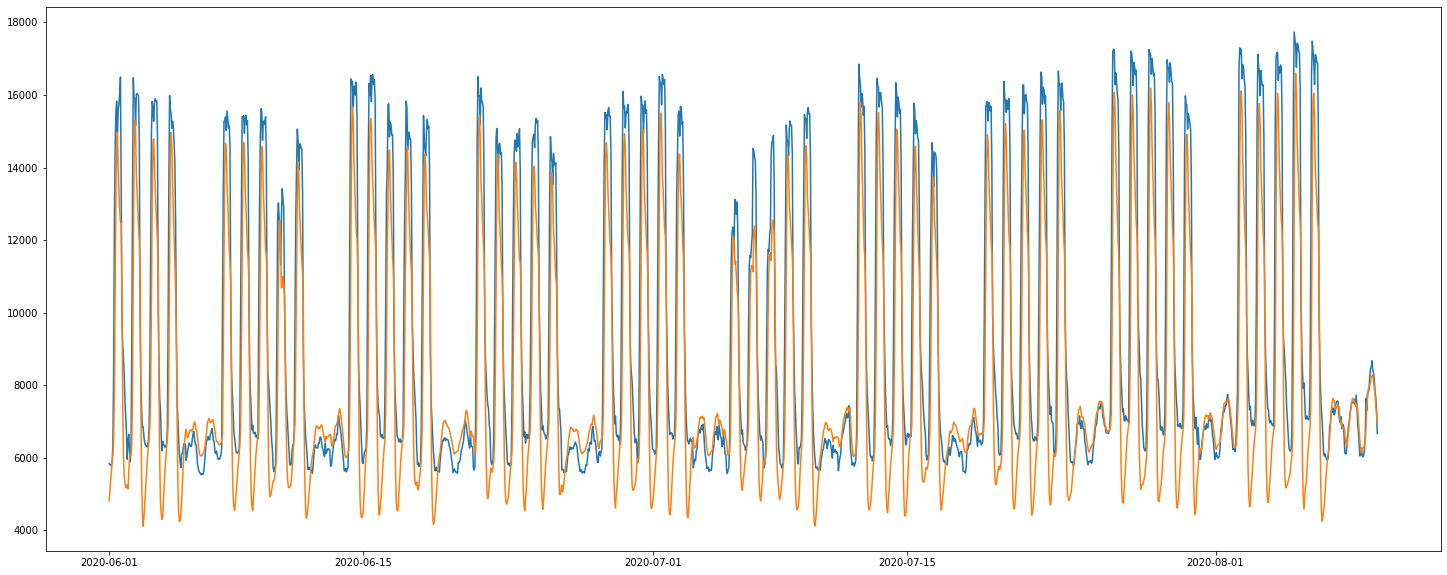

In [64]:
pred=[]

def create_model(stateful,batch_size, n_steps, n_features):
    model = Sequential()
    model.add(LSTM(16,
                   batch_input_shape=(batch_size, n_steps, n_features),
                   stateful=stateful
                   ))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    return model

batch_size = 1
epochs = 11

x, y = step_split(scaler.transform(time_table[[8]]), n_steps, n_features, n_predict_steps)
y = scaler.inverse_transform(y)

model_stateful = create_model(True, batch_size, n_steps, n_features)
    
model_stateful.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=1,
                      verbose=1,
                      shuffle=False,
                      validation_data=(x_test, y_test))

y_hat = model_stateful.predict(x, batch_size=batch_size)
y_hat = scaler.inverse_transform(y_hat)
pred.append(y_hat)

plt.figure(figsize=(25, 10))
plt.plot(time_table[[8]].index[:len(y_hat)],y[:len(y_hat)])
plt.plot(time_table[[8]].index[:len(y_hat)],y_hat)
plt.show()

In [65]:
pred_1=np.array(pred)

In [66]:
pred_1.shape

(1, 1679, 1)

In [67]:
pred_2=pred_1.reshape(1679,1)

In [68]:
df_pred=pd.DataFrame(pred_2)

In [69]:
df_y=pd.DataFrame(y)

In [70]:
df_pred

,0
0,4808.667969
1,5052.035156
2,5346.350586
3,5619.751953
4,5873.514648
...,...
1674,7934.187012
1675,7733.710449
1676,7429.115723
1677,7210.524902


In [71]:
df_pred[-168:]

,0
1511,5114.141113
1512,5388.536133
1513,5705.586914
1514,6117.865234
1515,6400.076172
...,...
1674,7934.187012
1675,7733.710449
1676,7429.115723
1677,7210.524902


In [72]:
te_8

num,8
date_time,
2020-08-18 00:00:00,5536.980000
2020-08-18 01:00:00,5494.572000
2020-08-18 02:00:00,5623.290000
2020-08-18 03:00:00,5535.720000
2020-08-18 04:00:00,5504.778000
...,...
2020-08-24 19:00:00,9973.646380
2020-08-24 20:00:00,9848.753514
2020-08-24 21:00:00,9245.020757


In [73]:
import numpy as np
def smape(a, f):
    return 1/len(a)*np.sum(2*np.abs(f-a)/(np.abs(a)+np.abs(f))*100)

In [74]:
from sklearn.metrics import mean_squared_error
a=te_8.values
b=df_pred[-168:].values

score=smape(a, b)

print('smape는', format(score), '입니다.')

smape는 22.74457632299166 입니다.


CNN
--

In [83]:
data=df_train.loc[df_train['num']==8]

In [84]:
target=data[['전력사용량(kWh)']]

In [85]:
data=data.drop(['전력사용량(kWh)'], axis=1)

minmaxscaler 적용

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data)
data_s=scaler.transform(data)

In [86]:
scaler.fit(target)
target_s=scaler.transform(target)

In [76]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf




model=Sequential()
model.add(Conv2D(32, kernel_size=(3,3), input_shape=(28,28,1), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [77]:
seed=0
np.random.seed(seed)
tf.random.set_seed(seed)

In [78]:
# 모델 최적화 설정
MODEL_DIR='./model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer=ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=10)

In [ ]:
history=model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=200, verbose=0, callbacks=[early_stopping_callback, checkpointer])

In [ ]:
print("\n Test Accuracy %.4f"%(model.evaluate(x_test, y_test)[1]))

In [ ]:
history.history.keys()

In [ ]:
# 시각화
y_vloss=history.history['val_loss']
y_loss=history.history['loss']

x_len=np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label="Testset_loss")
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()